Name: Jonathan Park <br>
Date: 2022.04.03

# Project Shappify: Vectorization and Sentiment Analysis Part 3
***

## Introduction

Taking the outputs of the English-only review texts from Part 2, the next steps will involve creating a Document-Term Matrix (DTM) and feeding it into a logistic regression (logit) model. To minimize any data leakage, pipelines will be implemented through sklearn's library. Obtaining optimal hyperparameters for the logit model will be iteratively achieved through a grid search that searches for optimal hyperparameters.

Several different logit models are created to also highlight the importance of the data-centric approach to machine learning by showing how the classification performance metrics of the model can change due to the different steps of text pre-processing previously implemented. For instance, we will see that a logit model of the reviews text without separating English-only reviews will show poorer model performance compared to a logit model with just the English review texts.

### Import Packages

In [1]:
# Array and dataframe manipulation libraries
import numpy as np
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Visual progress bar library
from tqdm import tqdm
tqdm.pandas()

# Sklearn library for model-related function
# and retrieving model metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, classification_report
from sklearn import set_config
set_config(display="diagram")

# Saving models
import pickle

### Defining Functions

I will be define some functions that will be used throughout the notebook here.

#### Train-Test Split Function

Create stratified train and test splits of the dataset via sklearn's library and simultaneously output the shapes of the dataframes created.

In [2]:
def train_test_split_print(X, y, size, random_state):
    
    """
    Create stratified, randomized train and test split of the inputted dataset
    and print the shapes of each train and test subset.

    Parameters
    ----------
    X : Arrays* representing the independent variable(s). Must be of same length of y.
    y : Arrays* representing the dependent variable. Must be of same length of X.
    size : An input argument for the train_test_split from sklearn
           library. Specification for proportion of dataset (float) or 
           absolute value (int) to be allocated for test subset.
    random_state : Seed number for random number generator for reproducible data.

    Returns
    -------
    X_remainder : Subset of X for train and cross-validation data.
    X_test : Subset of X for test data.
    y_remainder : Subset of y for train and cross-validation data.
    y_test : Subset of y for test data.
    
    * refers to arrays as defined by sklearn's train_test_split function documentation.
    """

    print_line = "\n=======================================================\n"

    print('\n Before Train and Test Split', print_line)
    print(f"Shape of X = {X.shape}; Shape of y = {y.shape}")
    
    
    # Splitting the data into train and test datasets using
    # train_test_split function from sklearn library
    X_remainder, X_test, y_remainder, y_test = train_test_split(X,
                                                                y,
                                                                test_size=size,
                                                                random_state=random_state,
                                                                stratify=y)

    print('\n\n After Train and Test Split', print_line)

    print('Train/Valiation Dataset \n')
    print(f"Shape of X_remainder = {X_remainder.shape}; Shape of y_remainder = {y_remainder.shape}")
    
    print('\n')

    print('Test Dataset \n')
    print(f"Shape of X_test = {X_test.shape}; Shape of y_test = {y_test.shape}")
    
    return (X_remainder, X_test, y_remainder, y_test)

#### Model Performance Metrics Function

Output the model classification report and confusion matrix for a given model.

In [3]:
def model_performance_metrics(model, X_train, y_train, X_test, y_test):

    """
    Prints the confusion matrix and classification report for train/remainder
    and test data subsets using the specified fitted model. Confusion matrix and 
    classification report functions are from sklearn library. Returns various
    performance metrics for the model on the train/remainder and test data subsets.

    Parameters
    ----------
    model : The fitted model used to predict classifications and assess performance metrics on. 
    X_train : Subset of X for train and cross-validation data (i.e., remainder).
    y_train : Subset of y for train and cross-validation data.
    X_test : Subset of X for test data.
    y_test : Subset of y for test data.
    
    
    Returns
    -------
    precision : Model precision on the train/remainder and test data subsets. 
    recall : Model recall on the train/remainder and test data subsets. 
    f1_score : Model harmonic mean scores on the train/remainder and test data subsets. 

    """

    # Define empty variables
    precision = []
    recall = []
    f1_score = []
    
    for title,x,y in (['Train Data', X_train, y_train],
                      ['Test Data', X_test, y_test]):

        print_line = "\n=======================================================\n"

        # Title
        print(f"Confusion matrix for {title}:", print_line)

        # Predict classifications
        y_pred = model.predict(x)

        # Display confusion matrix; function from sklearn library
        conmat = pd.DataFrame(data = confusion_matrix(y, y_pred),
                              index = ['True 0 [Negative Review]', 'True 1 [Positive Review]'],
                              columns = ['Predicted 0 [Negative Review]', 'Predicted 1 [Positive Review]']
                             )
        
        display(conmat)
        
        # Title
        print(f"Classification Report for {title}:", print_line)

        # Create target names for classification report labels
        target_names = ['Negative (Class 0)', 'Positive (Class 1)']
        
        # Print classification report output; function from sklearn library
        report_initial = classification_report(y, y_pred, target_names=target_names)
        
        print(report_initial)
        
        # Classification report output as dict
        report_dict = classification_report(y, y_pred, target_names=target_names, output_dict=True)

        # Create dataframe from the classification report
        metrics_df = pd.DataFrame(report_dict).T
        metrics_df = metrics_df.iloc[0:2, 0:3]

        # Append performance metrics to corresponding variables initially defined
        precision.append(f"{metrics_df['precision'].values[0]*100:0.1f}%")
        precision.append(f"{metrics_df['precision'].values[1]*100:0.1f}%")
        recall.append(f"{metrics_df['recall'].values[0]*100:0.1f}%")
        recall.append(f"{metrics_df['recall'].values[1]*100:0.1f}%")
        f1_score.append(f"{metrics_df['f1-score'].values[0]*100:0.1f}%")
        f1_score.append(f"{metrics_df['f1-score'].values[1]*100:0.1f}%")


    return precision, recall, f1_score

## All Language Reviews with No Rounds of Text Pre-processing

I will first fit a logistic regression model on the `reviews_df_part_1` that contains no text pre-processing or language detection and separation.

### Import Data - Reviews from Part 1

In [4]:
# Import dataset
reviews_df = pd.read_pickle('reviews_df_part_1.pkl')

Quick glimpse of the top 5 and bottom 5 rows.

In [5]:
reviews_df.head()

,app_name,author,rating,review_date,review_text,helpful_count,dev_reply_text,dev_reply_date,is_review_good
0,Instant Search +,Consuela,5,2020-08-06,Great and super fast customer service! Highly ...,0,NaN,NaT,1
1,Instant Search +,L'Atelier Global,5,2020-08-04,"Still setting up my store, and after initially...",0,NaN,NaT,1
2,Instant Search +,city'super E-Shop,5,2020-08-04,"This is an excellent search app, which they ha...",0,NaN,NaT,1
3,Instant Search +,PortableHandwashing.com,5,2020-07-30,"A+, great great great customer service! thanks...",0,NaN,NaT,1
4,Instant Search +,ICCTUNING,5,2020-07-28,"I'm begginig to use this app, the search engin...",0,NaN,NaT,1


In [6]:
reviews_df.tail()

,app_name,author,rating,review_date,review_text,helpful_count,dev_reply_text,dev_reply_date,is_review_good
446968,COD Order Confirmation,Feltin,5,2018-03-22,Very very well explained tutorial. Seems very ...,0,NaN,NaT,1
446969,COD Order Confirmation,Srstore09,5,2018-01-23,Finally we have an App for for CoD Confirmatio...,0,NaN,NaT,1
446970,COD Order Confirmation,Eshop Fashion,5,2018-01-05,"Useful, App help us to reduce cost & time. hig...",0,NaN,NaT,1
446971,COD Order Confirmation,Arabicworld,1,2017-06-15,Do not purchase this application!\nit's like s...,0,NaN,NaT,0
446972,COD Order Confirmation,Ethnicyug,5,2016-01-06,​​A must​ have​ app for those having e-stores ...,0,NaN,NaT,1


In [7]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 446973 entries, 0 to 446972
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   app_name        446973 non-null  object        
 1   author          446973 non-null  object        
 2   rating          446973 non-null  int64         
 3   review_date     446973 non-null  datetime64[ns]
 4   review_text     446973 non-null  object        
 5   helpful_count   446973 non-null  int64         
 6   dev_reply_text  47542 non-null   object        
 7   dev_reply_date  47542 non-null   datetime64[ns]
 8   is_review_good  446973 non-null  int32         
dtypes: datetime64[ns](2), int32(1), int64(2), object(4)
memory usage: 32.4+ MB


### Separate and Define X and y Variables from the Dataframe

The `X` variable will be the `review_text` and the `y` variable will be the `is_review_good` binary variable.

In [8]:
X = reviews_df['review_text']

In [9]:
# Check the shape
X.shape

(446973,)

In [10]:
y = reviews_df['is_review_good']

In [11]:
# Check the shape
y.shape

(446973,)

### Train-Test Split

I will now implement a train-test split using a 90:10 ratio. This ratio was chosen because of the large magnitude of the data that is available. This ratio will be used throughout the rest of the notebook.

In [12]:
# Train-test split for non-text pre-processed review data
X_remainder, X_test, y_remainder, y_test = train_test_split_print(X, 
                                                                  y, 
                                                                  size = 0.1, 
                                                                  random_state = 1)


 Before Train and Test Split 

Shape of X = (446973,); Shape of y = (446973,)


 After Train and Test Split 

Train/Valiation Dataset 

Shape of X_remainder = (402275,); Shape of y_remainder = (402275,)


Test Dataset 

Shape of X_test = (44698,); Shape of y_test = (44698,)


### Logistic Regression Model 0

I will create a simple logistic regression model with a plain CountVectorizer to retrieve the baseline model performance metrics. No cross-fold validation and optimized hyperparameters will be used at this point.

In [13]:
# Define a pipeline that implements the steps for the transform and final estimator
# Alternative method can be to use make_pipeline function in sklearn

# Instantiate transformer and estimator or steps for the pipeline
estimators = [("cv", CountVectorizer()),
              ("logit_model", LogisticRegression(max_iter=200,
                              solver='liblinear',
                              penalty='l1',
                              random_state=1))]

# Instantiate pipeline
logit_v0_pipe = Pipeline(estimators, verbose=True)

Fit the pipeline to the train dataset.

In [14]:
# # Fit pipeline 
# logit_v0_pipe.fit(X_remainder, y_remainder)

Save the fitted model to a pickle file.

In [15]:
# # Save the model to a pickle file
# # https://stackoverflow.com/questions/10592605/save-classifier-to-disk-in-scikit-learn
# with open('logit_v0_pipe.pkl', 'wb') as f:
#     pickle.dump(logit_v0_pipe, f)

Load the fitted model from a pickle file.

In [16]:
# Load pickled model file
with open('logit_v0_pipe.pkl', 'rb') as f:
    logit_v0_pipe = pickle.load(f)

Click on elements below for details of each step in the pipeline diagram.

In [17]:
# Display pipeline diagram
logit_v0_pipe

Pipeline(steps=[('cv', CountVectorizer()),
                ('logit_model',
                 LogisticRegression(max_iter=200, penalty='l1', random_state=1,
                                    solver='liblinear'))],
         verbose=True)

Score the model on both train and test datasets and output the accuracy of the model.

In [18]:
# Train and test score from logit_v0_pipe
accuracy = []

accuracy.append(f"{logit_v0_pipe.score(X_remainder, y_remainder) * 100:0.1f}%")
accuracy.append(f"{logit_v0_pipe.score(X_test, y_test) * 100:0.1f}%")

print(f"Train score: {accuracy[0]}")
print(f"Test score: {accuracy[1]}")

Train score: 97.2%
Test score: 96.7%


It appears the model performed well. However, this may be solely a result of the model's ability to correctly classify positive reviews very well but not the negative reviews due to the class imbalance.

I will retrieve the confusion matrix and classification report of the performance metrics from the model for both train and test datasets to observe the model's ability to classify positive reviews and negative reviews, separately.

In [19]:
# Use the function defined earlier for model performance metrics
precision, recall, f1_score = model_performance_metrics(logit_v0_pipe,
                                                        X_remainder,
                                                        y_remainder,
                                                        X_test,
                                                        y_test)

Confusion matrix for Train Data: 



,Predicted 0 [Negative Review],Predicted 1 [Positive Review]
True 0 [Negative Review],19049,8992
True 1 [Positive Review],2262,371972


Classification Report for Train Data: 

                    precision    recall  f1-score   support

Negative (Class 0)       0.89      0.68      0.77     28041
Positive (Class 1)       0.98      0.99      0.99    374234

          accuracy                           0.97    402275
         macro avg       0.94      0.84      0.88    402275
      weighted avg       0.97      0.97      0.97    402275

Confusion matrix for Test Data: 



,Predicted 0 [Negative Review],Predicted 1 [Positive Review]
True 0 [Negative Review],1990,1126
True 1 [Positive Review],367,41215


Classification Report for Test Data: 

                    precision    recall  f1-score   support

Negative (Class 0)       0.84      0.64      0.73      3116
Positive (Class 1)       0.97      0.99      0.98     41582

          accuracy                           0.97     44698
         macro avg       0.91      0.81      0.85     44698
      weighted avg       0.96      0.97      0.96     44698



In [20]:
# Compile the model performance metrics into a dataframe
model_compilation = pd.DataFrame({
                                    'Model': 'logit_v0',
                                    'Dataset': ['Train_Remainder', 
                                                'Train_Remainder',
                                                'Test', 
                                                'Test'],
                                    'Target':['Negative (Class 0)', 
                                              'Positive (Class 1)',
                                              'Negative (Class 0)', 
                                              'Positive (Class 1)'],
                                    'Accuracy': [' ', accuracy[0], ' ', accuracy[1]],
                                    'Precision': precision,
                                    'Recall': recall,
                                    'F1-Score': f1_score
                                },
                                index= range(0,4))

In [21]:
# Print the model compiled results
model_compilation

,Model,Dataset,Target,Accuracy,Precision,Recall,F1-Score
0,logit_v0,Train_Remainder,Negative (Class 0),,89.4%,67.9%,77.2%
1,logit_v0,Train_Remainder,Positive (Class 1),97.2%,97.6%,99.4%,98.5%
2,logit_v0,Test,Negative (Class 0),,84.4%,63.9%,72.7%
3,logit_v0,Test,Positive (Class 1),96.7%,97.3%,99.1%,98.2%


When taking a closer look at the model performance metrics, the precision and recall for correctly predicting positive reviews are excellent, with $\approx$ 97-99% for both train and test datasets. Although the precision for train and test data are $\approx$ 84-89%, the recall for correctly identifying negative reviews is $\approx$ 64-68%. This is due to the potential 'noise' in the data as a result of nonsensical text and/or other language reviews that are confusing the model. In addition,   the class imbalance between the total positive and negative reviews may also affect the model's ability to identify patterns within the dataset. Let's see how this changes with the different pre-processed datasets.

I will be focusing on the train and test performance metrics for correctly identifying negative reviews with the different model iterations.

#### Odds Ratios

This section is a quick demonstration and visualization of the specific features or words that were most and least predictive of positive and negative reviews from logit_v0.

I will extract the logit model coefficients, take the exponent to retrieve odds ratios, and compile it into a dataframe.

In [22]:
# Create dataframe of the logit coefficients and odds ratios
logit_coef_df = pd.DataFrame({"Feature": logit_v0_pipe[0].get_feature_names(),
                              "Logit_Coefficient": logit_v0_pipe[1].coef_[0],
                              "Odds_Ratio": np.exp(logit_v0_pipe[1].coef_[0])
                             })


Quick glimpse of the top 5 and bottom 5 rows.

In [23]:
logit_coef_df.head()

,Feature,Logit_Coefficient,Odds_Ratio
0,00,-0.879948,0.414804
1,000,-0.264142,0.767865
2,0000,0.000000,1.000000
3,000000,0.000000,1.000000
4,0000000,0.000000,1.000000


In [24]:
logit_coef_df.tail()

,Feature,Logit_Coefficient,Odds_Ratio
98580,ｕｓｅ,0.0,1.0
98581,ｕｓｅｆｕｌ,0.0,1.0
98582,ｖｅｒｙ,0.0,1.0
98583,ｗｅｂｓｉｔｅ,0.0,1.0
98584,ｙｏｕ,0.0,1.0


A peculiar observation for the bottom 5 rows in the logit coefficients dataframe are the widely spaced out letters in the words `ｕｓｅ` or `ｕｓｅｆｕｌ`. It appears that the font style of the text is responsible for the difference. The specific review with the different font style is in index 213,346 in the `reviews_df`.

I will now sort the odds ratios and convert coefficients that were under 1 into negative coefficients for visualization purposes. The conversion is completed by taking the corresponding odds ratios and inversing it and turning it into a negative for appropriate visualization on the graph.

In [25]:
# Filter the odds ratios and convert coefficients that were under 1 into negative coefficients for visualization
# Odds ratios under 1 are inversed to retrieve appropriate odds ratio values
logit_coef_df['Plotting_Odds_Ratio'] = np.where(logit_coef_df['Odds_Ratio'] >= 1.0, 
                                                logit_coef_df['Odds_Ratio'],
                                                -1 / logit_coef_df['Odds_Ratio'])

In [26]:
# Sort odds ratio values
logit_coef_df = logit_coef_df.sort_values('Odds_Ratio', ascending = False)

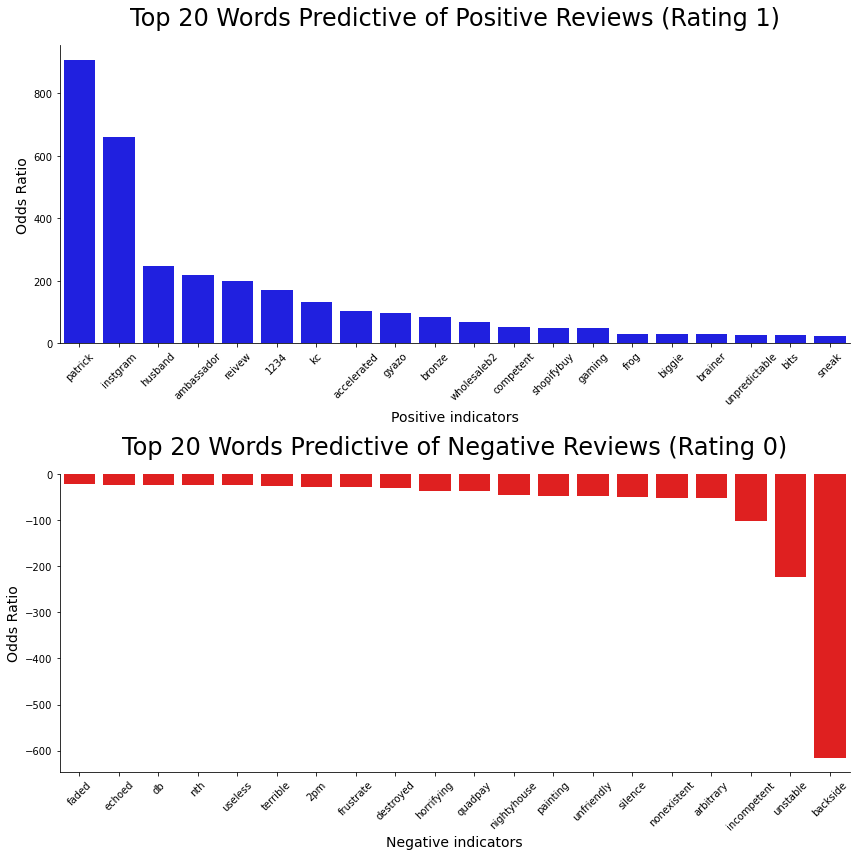

In [27]:
# Visualise the positive and negative tokens and the corresponding log odds ratio of their
# coefficients from the logistic regression
plt.subplots(nrows=2, ncols=1, figsize=(12, 12))


################### Positive Indicators Bar Plot ###################
# largest positive odds ratio -> tokens indicating positive sentiment 

plt.subplot(2, 1, 1)
sns.barplot(x = logit_coef_df['Feature'].head(20), y = logit_coef_df['Plotting_Odds_Ratio'].head(20), color="blue")

# Set titles and labels
plt.title(f"Top 20 Words Predictive of Positive Reviews (Rating 1)", size=24, pad=20)
plt.xlabel('Positive indicators', size=14)
plt.ylabel('Odds Ratio', size=14)
plt.xticks(rotation = 45)

# Remove top and top right graph borders
sns.despine()

plt.tight_layout()

################### Negative Indicators Bar Plot ###################
# largest negative odds ratio -> tokens indicating negative sentiment

plt.subplot(2, 1, 2)
sns.barplot(x = logit_coef_df['Feature'].tail(20), y = logit_coef_df['Plotting_Odds_Ratio'].tail(20), color="red")

# Set titles and labels
plt.title(f"Top 20 Words Predictive of Negative Reviews (Rating 0)", size=24, pad=20)
plt.xlabel('Negative indicators', size=14)
plt.ylabel('Odds Ratio', size=14)
plt.xticks(rotation = 45)

# Remove top and top right graph borders
sns.despine()

plt.tight_layout()
plt.show()


We can see that there are a lot of nonsensical text. These were the motivations for implementation of text pre-processing and language filtering. As a side note, it appears that the magnitudes of the odds ratios are very large (in the 100s). This may be a function of the absent regularization parameters (i.e., C parameter for strength of regularization). Optimal hyperparameters, including regularization, will be explored further in the notebook.

## English-Only Reviews from Round 1 of Pre-processing

I will now fit a logistic regression model on the `reviews_df_clean_1_en_part_2` that contains round 1 of text pre-processing and English-only reviews.

### Import Data - English-Only Reviews from Round 1 of Pre-processing

In [28]:
# Import dataset
reviews_df_clean_1_en = pd.read_pickle('reviews_df_clean_1_en_part_2.pkl')

Quick glimpse of the top 5 and bottom 5 rows.

In [29]:
reviews_df_clean_1_en.head()

,app_name,review_date,review_text,dev_reply_text,dev_reply_date,is_review_good,lang_iso
0,Instant Search +,2020-08-06,Great and super fast customer service! Highly ...,NaN,NaT,1,en
1,Instant Search +,2020-08-04,"Still setting up my store, and after initially...",NaN,NaT,1,en
2,Instant Search +,2020-08-04,"This is an excellent search app, which they ha...",NaN,NaT,1,en
3,Instant Search +,2020-07-30,"A+, great great great customer service! thanks...",NaN,NaT,1,en
4,Instant Search +,2020-07-28,"I'm begginig to use this app, the search engin...",NaN,NaT,1,en


In [30]:
reviews_df_clean_1_en.tail()

,app_name,review_date,review_text,dev_reply_text,dev_reply_date,is_review_good,lang_iso
446968,COD Order Confirmation,2018-03-22,Very very well explained tutorial. Seems very ...,NaN,NaT,1,en
446969,COD Order Confirmation,2018-01-23,Finally we have an App for for CoD Confirmatio...,NaN,NaT,1,en
446970,COD Order Confirmation,2018-01-05,"Useful, App help us to reduce cost & time. hig...",NaN,NaT,1,en
446971,COD Order Confirmation,2017-06-15,Do not purchase this application! it's like sh...,NaN,NaT,0,en
446972,COD Order Confirmation,2016-01-06,​​A must​ have​ app for those having e-stores ...,NaN,NaT,1,en


In [31]:
reviews_df_clean_1_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 426568 entries, 0 to 446972
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   app_name        426568 non-null  object        
 1   review_date     426568 non-null  datetime64[ns]
 2   review_text     426568 non-null  object        
 3   dev_reply_text  45280 non-null   object        
 4   dev_reply_date  45280 non-null   datetime64[ns]
 5   is_review_good  426568 non-null  int32         
 6   lang_iso        426568 non-null  object        
dtypes: datetime64[ns](2), int32(1), object(4)
memory usage: 24.4+ MB


### Separate and Define X and y Variables from the Dataframe

The `X` variable will be the `review_text` and the `y` variable will be the `is_review_good` binary variable.

In [32]:
X = reviews_df_clean_1_en['review_text']

In [33]:
# Check the shape
X.shape

(426568,)

In [34]:
y = reviews_df_clean_1_en['is_review_good']

In [35]:
# Check the shape
y.shape

(426568,)

### Train-Test Split

Create the train-test split data.

In [36]:
# Train-test split for round 1 of pre-processed data
X_remainder, X_test, y_remainder, y_test = train_test_split_print(X, 
                                                                  y, 
                                                                  size = 0.1, 
                                                                  random_state = 1)


 Before Train and Test Split 

Shape of X = (426568,); Shape of y = (426568,)


 After Train and Test Split 

Train/Valiation Dataset 

Shape of X_remainder = (383911,); Shape of y_remainder = (383911,)


Test Dataset 

Shape of X_test = (42657,); Shape of y_test = (42657,)


### Logistic Regression Model 1

I will create another logit model. But this time, I will use the English-only language reviews dataframe from round 1 of text pre-processing.

In [37]:
# Define a pipeline that implements the steps for the transforms and final estimator

# Instantiate transformer and estimator or steps for the pipeline
estimators = [("cv", CountVectorizer()),
              ("logit_model", LogisticRegression(max_iter=200,
                              solver='liblinear',
                              penalty='l1',
                              random_state=1))]

# Instantiate pipeline
logit_v1_pipe = Pipeline(estimators, verbose = True)

Fit the pipeline to the train dataset.

In [38]:
# # Fit pipeline
# logit_v1_pipe.fit(X_remainder, y_remainder)

Save the fitted model to a pickle file.

In [39]:
# # Save the model to a pickle file
# # https://stackoverflow.com/questions/10592605/save-classifier-to-disk-in-scikit-learn
# with open('logit_v1_pipe.pkl', 'wb') as f:
#     pickle.dump(logit_v1_pipe, f)

Load the fitted model from a pickle file.

In [40]:
# Load pickled model file
with open('logit_v1_pipe.pkl', 'rb') as f:
    logit_v1_pipe = pickle.load(f)

Click on elements below for details of each step in the pipeline diagram.

In [41]:
# Display pipeline diagram
logit_v1_pipe  

Pipeline(steps=[('cv', CountVectorizer()),
                ('logit_model',
                 LogisticRegression(max_iter=200, penalty='l1', random_state=1,
                                    solver='liblinear'))],
         verbose=True)

Score the model on both train and test datasets and output the accuracy of the model.

In [42]:
# Train and test score from logit
accuracy = []

accuracy.append(f"{logit_v1_pipe.score(X_remainder, y_remainder) * 100:0.1f}%")
accuracy.append(f"{logit_v1_pipe.score(X_test, y_test) * 100:0.1f}%")

print(f"Train score: {accuracy[0]}")
print(f"Test score: {accuracy[1]}")

Train score: 97.3%
Test score: 96.7%


I will retrieve the confusion matrix and classification report of the performance metrics from the model for both train and test datasets to observe the model's ability to classify positive reviews and negative reviews, separately.

In [43]:
# Use the function defined earlier for model performance metrics
precision, recall, f1_score = model_performance_metrics(logit_v1_pipe, 
                                                        X_remainder, 
                                                        y_remainder, 
                                                        X_test, 
                                                        y_test)

Confusion matrix for Train Data: 



,Predicted 0 [Negative Review],Predicted 1 [Positive Review]
True 0 [Negative Review],18593,8250
True 1 [Positive Review],2242,354826


Classification Report for Train Data: 

                    precision    recall  f1-score   support

Negative (Class 0)       0.89      0.69      0.78     26843
Positive (Class 1)       0.98      0.99      0.99    357068

          accuracy                           0.97    383911
         macro avg       0.93      0.84      0.88    383911
      weighted avg       0.97      0.97      0.97    383911

Confusion matrix for Test Data: 



,Predicted 0 [Negative Review],Predicted 1 [Positive Review]
True 0 [Negative Review],1927,1056
True 1 [Positive Review],341,39333


Classification Report for Test Data: 

                    precision    recall  f1-score   support

Negative (Class 0)       0.85      0.65      0.73      2983
Positive (Class 1)       0.97      0.99      0.98     39674

          accuracy                           0.97     42657
         macro avg       0.91      0.82      0.86     42657
      weighted avg       0.97      0.97      0.97     42657



In [44]:
# Compile the model performance metrics into a dataframe
model_compilation = model_compilation.append(pd.DataFrame({
                                                            'Model': 'logit_v1',
                                                            'Dataset': ['Train_Remainder', 
                                                                        'Train_Remainder',
                                                                        'Test', 
                                                                        'Test'],
                                                            'Target':['Negative (Class 0)', 
                                                                      'Positive (Class 1)',
                                                                      'Negative (Class 0)', 
                                                                      'Positive (Class 1)'],
                                                            'Accuracy': [' ', accuracy[0], ' ', accuracy[1]],
                                                            'Precision': precision,
                                                            'Recall': recall,
                                                            'F1-Score': f1_score
                                                        },
                                                        index= range(4,8)))

In [45]:
# Print the model compiled results
model_compilation

,Model,Dataset,Target,Accuracy,Precision,Recall,F1-Score
0,logit_v0,Train_Remainder,Negative (Class 0),,89.4%,67.9%,77.2%
1,logit_v0,Train_Remainder,Positive (Class 1),97.2%,97.6%,99.4%,98.5%
2,logit_v0,Test,Negative (Class 0),,84.4%,63.9%,72.7%
3,logit_v0,Test,Positive (Class 1),96.7%,97.3%,99.1%,98.2%
4,logit_v1,Train_Remainder,Negative (Class 0),,89.2%,69.3%,78.0%
5,logit_v1,Train_Remainder,Positive (Class 1),97.3%,97.7%,99.4%,98.5%
6,logit_v1,Test,Negative (Class 0),,85.0%,64.6%,73.4%
7,logit_v1,Test,Positive (Class 1),96.7%,97.4%,99.1%,98.3%


In comparing the train dataset precision and recall for negative reviews between `logit_v0` and `logit_v1`, we can see a slight decrease in precision of 0.2% (89.4% to 89.2%) but an increase in recall of 1.4% (67.9% to 69.3%). For the test dataset,  we see a slight increase in precision of 0.6% (84.4% to 85.0%) and in recall of 0.7% (63.9% to 64.6%). The slight improvements in precision and recall for negative reviews are a result of using English-only reviews from Round 1 of text pre-processing and highlights the potential of the data-centric approach.

## English-Only Reviews from Round 2 of Pre-processing

I will now fit a logistic regression model on the `reviews_df_clean_2_en_part_2` that underwent round 2 of text pre-processing and contains English-only reviews.

### Import Data - English-Only Reviews from Round 2 of Pre-processing

In [46]:
# Import dataset
reviews_df_clean_2_en = pd.read_pickle('reviews_df_clean_2_en_part_2.pkl')

Quick glimpse of the top 5 and bottom 5 rows.

In [47]:
reviews_df_clean_2_en.head()

,app_name,review_date,review_text,dev_reply_text,dev_reply_date,is_review_good,lang_iso
0,Instant Search +,2020-08-06,great and super fast customer service highly c...,NaN,NaT,1,en
1,Instant Search +,2020-08-04,still setting up my store and after initially ...,NaN,NaT,1,en
2,Instant Search +,2020-08-04,this is an excellent search app which they hav...,NaN,NaT,1,en
3,Instant Search +,2020-07-30,a great great great customer service thanks to...,NaN,NaT,1,en
4,Instant Search +,2020-07-28,i am begginig to use this app the search engin...,NaN,NaT,1,en


In [48]:
reviews_df_clean_2_en.tail()

,app_name,review_date,review_text,dev_reply_text,dev_reply_date,is_review_good,lang_iso
446968,COD Order Confirmation,2018-03-22,very very well explained tutorial seems very e...,NaN,NaT,1,en
446969,COD Order Confirmation,2018-01-23,finally we have an app for for cod confirmatio...,NaN,NaT,1,en
446970,COD Order Confirmation,2018-01-05,useful app help us to reduce cost time highly ...,NaN,NaT,1,en
446971,COD Order Confirmation,2017-06-15,do not purchase this application it is like sh...,NaN,NaT,0,en
446972,COD Order Confirmation,2016-01-06,​​a must​ have​ app for those having e stores ...,NaN,NaT,1,en


In [49]:
reviews_df_clean_2_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 427298 entries, 0 to 446972
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   app_name        427298 non-null  object        
 1   review_date     427298 non-null  datetime64[ns]
 2   review_text     427298 non-null  object        
 3   dev_reply_text  45305 non-null   object        
 4   dev_reply_date  45305 non-null   datetime64[ns]
 5   is_review_good  427298 non-null  int32         
 6   lang_iso        427298 non-null  object        
dtypes: datetime64[ns](2), int32(1), object(4)
memory usage: 24.5+ MB


### Separate and Define X and y Variables from the Dataframe

The `X` variable will be the `review_text` and the `y` variable will be the `is_review_good` binary variable.

In [50]:
X = reviews_df_clean_2_en['review_text']

In [51]:
# Check the shape
X.shape

(427298,)

In [52]:
y = reviews_df_clean_2_en['is_review_good']

In [53]:
# Check the shape
y.shape

(427298,)

### Train-Test Split

Create the train-test split data.

In [54]:
# Train-test split for round 2 of pre-processed data
X_remainder, X_test, y_remainder, y_test = train_test_split_print(X, 
                                                                  y, 
                                                                  size = 0.1, 
                                                                  random_state = 1)


 Before Train and Test Split 

Shape of X = (427298,); Shape of y = (427298,)


 After Train and Test Split 

Train/Valiation Dataset 

Shape of X_remainder = (384568,); Shape of y_remainder = (384568,)


Test Dataset 

Shape of X_test = (42730,); Shape of y_test = (42730,)


### Logistic Regression Model 2

I will create another logit model. But this time, I will use the English-only language reviews dataframe from round 2 of text pre-processing.

In [55]:
# Define a pipeline that implements the steps for the transforms and final estimator

# Instantiate transformer and estimator or steps for the pipeline
estimators = [("cv", CountVectorizer()),
              ("logit_model", LogisticRegression(max_iter=200,
                              solver='liblinear',
                              penalty='l1',
                              random_state=1))]

# Instantiate pipeline
logit_v2_pipe = Pipeline(estimators, verbose = True)

Fit the pipeline to the training dataset.

In [56]:
# # Fit pipeline
# logit_v2_pipe.fit(X_remainder, y_remainder)

Save the fitted model to a pickle file.

In [57]:
# # Save the model to a pickle file
# # https://stackoverflow.com/questions/10592605/save-classifier-to-disk-in-scikit-learn
# with open('logit_v2_pipe.pkl', 'wb') as f:
#     pickle.dump(logit_v2_pipe, f)

Load the fitted model from a pickle file.

In [58]:
# Load pickled model file
with open('logit_v2_pipe.pkl', 'rb') as f:
    logit_v2_pipe = pickle.load(f)

Click on elements below for details of each step in the pipeline diagram.

In [59]:
# Display pipeline diagram
logit_v2_pipe

Pipeline(steps=[('cv', CountVectorizer()),
                ('logit_model',
                 LogisticRegression(max_iter=200, penalty='l1', random_state=1,
                                    solver='liblinear'))],
         verbose=True)

Score the model on both train and test datasets and output the accuracy of the model.

In [60]:
# Train and test score from logit
accuracy = []

accuracy.append(f"{logit_v2_pipe.score(X_remainder, y_remainder) * 100:0.1f}%")
accuracy.append(f"{logit_v2_pipe.score(X_test, y_test) * 100:0.1f}%")

print(f"Train score: {accuracy[0]}")
print(f"Test score: {accuracy[1]}")

Train score: 97.2%
Test score: 96.6%


Retrieve confusion matrix and classification report of the performance metrics from the model for both train and test datasets.

In [61]:
# Use the function defined earlier for model performance metrics
precision, recall, f1_score = model_performance_metrics(logit_v2_pipe, 
                                                        X_remainder, 
                                                        y_remainder, 
                                                        X_test, 
                                                        y_test)

Confusion matrix for Train Data: 



,Predicted 0 [Negative Review],Predicted 1 [Positive Review]
True 0 [Negative Review],18534,8314
True 1 [Positive Review],2290,355430


Classification Report for Train Data: 

                    precision    recall  f1-score   support

Negative (Class 0)       0.89      0.69      0.78     26848
Positive (Class 1)       0.98      0.99      0.99    357720

          accuracy                           0.97    384568
         macro avg       0.93      0.84      0.88    384568
      weighted avg       0.97      0.97      0.97    384568

Confusion matrix for Test Data: 



,Predicted 0 [Negative Review],Predicted 1 [Positive Review]
True 0 [Negative Review],1889,1094
True 1 [Positive Review],354,39393


Classification Report for Test Data: 

                    precision    recall  f1-score   support

Negative (Class 0)       0.84      0.63      0.72      2983
Positive (Class 1)       0.97      0.99      0.98     39747

          accuracy                           0.97     42730
         macro avg       0.91      0.81      0.85     42730
      weighted avg       0.96      0.97      0.96     42730



In [62]:
# Compile the model performance metrics into a dataframe
model_compilation = model_compilation.append(pd.DataFrame({
                                                            'Model': 'logit_v2',
                                                            'Dataset': ['Train_Remainder', 
                                                                        'Train_Remainder',
                                                                        'Test', 
                                                                        'Test'],
                                                            'Target':['Negative (Class 0)', 
                                                                      'Positive (Class 1)',
                                                                      'Negative (Class 0)', 
                                                                      'Positive (Class 1)'],
                                                            'Accuracy': [' ', accuracy[0], ' ', accuracy[1]],
                                                            'Precision': precision,
                                                            'Recall': recall,
                                                            'F1-Score': f1_score
                                                        },
                                                        index= range(8,12)))

In [63]:
# Print the model compiled results
model_compilation

,Model,Dataset,Target,Accuracy,Precision,Recall,F1-Score
0,logit_v0,Train_Remainder,Negative (Class 0),,89.4%,67.9%,77.2%
1,logit_v0,Train_Remainder,Positive (Class 1),97.2%,97.6%,99.4%,98.5%
2,logit_v0,Test,Negative (Class 0),,84.4%,63.9%,72.7%
3,logit_v0,Test,Positive (Class 1),96.7%,97.3%,99.1%,98.2%
4,logit_v1,Train_Remainder,Negative (Class 0),,89.2%,69.3%,78.0%
5,logit_v1,Train_Remainder,Positive (Class 1),97.3%,97.7%,99.4%,98.5%
6,logit_v1,Test,Negative (Class 0),,85.0%,64.6%,73.4%
7,logit_v1,Test,Positive (Class 1),96.7%,97.4%,99.1%,98.3%
8,logit_v2,Train_Remainder,Negative (Class 0),,89.0%,69.0%,77.8%
9,logit_v2,Train_Remainder,Positive (Class 1),97.2%,97.7%,99.4%,98.5%


In comparing the test data's precision and recall for `Negative` reviews between `logit_v1` and `logit_v2`, we can see a decrease of 0.8% (85.0% to 84.2%) in precision, and a decrease of 1.3% (64.6% to 63.3%) in recall. However, the major difference is the number of features that were included in each model.

If we recall, the vectorization of data from the 2nd round of pre-processing resulted in a increase of vocabulary size to 81,035. This is in contrast to round 1's English-only reviews vocabulary of 73,637. This was due to the preservation of additional English-language reviews. We can see the slight impact this had on precision and the recall for the model.

## Text Normalized English Reviews from Round 3 of Pre-processing

I will now fit a logistic regression model on the `reviews_df_clean_3a_en_verb_only_lemmatized_part_2` that contains the text normalization (verbs only) during round 3 of text pre-processing and English-only reviews.

### Import Data - Verb Lemmatized English-Only Reviews from Round 3 of Pre-processing

In [64]:
# Import dataset
reviews_df_clean_3_en = pd.read_pickle('reviews_df_clean_3a_en_verb_only_lemmatized_part_2.pkl')

Quick glimpse of the top 5 and bottom 5 rows.

In [65]:
reviews_df_clean_3_en.head()

,app_name,review_date,review_text,dev_reply_text,dev_reply_date,is_review_good,lang_iso
0,Instant Search +,2020-08-06,great and super fast customer service highly c...,NaN,NaT,1,en
1,Instant Search +,2020-08-04,still set up my store and after initially pay ...,NaN,NaT,1,en
2,Instant Search +,2020-08-04,this be an excellent search app which they hav...,NaN,NaT,1,en
3,Instant Search +,2020-07-30,a great great great customer service thanks to...,NaN,NaT,1,en
4,Instant Search +,2020-07-28,i be begginig to use this app the search engin...,NaN,NaT,1,en


In [66]:
reviews_df_clean_3_en.tail()

,app_name,review_date,review_text,dev_reply_text,dev_reply_date,is_review_good,lang_iso
446968,COD Order Confirmation,2018-03-22,very very well explain tutorial seem very easy...,NaN,NaT,1,en
446969,COD Order Confirmation,2018-01-23,finally we have an app for for cod confirmatio...,NaN,NaT,1,en
446970,COD Order Confirmation,2018-01-05,useful app help us to reduce cost time highly ...,NaN,NaT,1,en
446971,COD Order Confirmation,2017-06-15,do not purchase this application it be like sh...,NaN,NaT,0,en
446972,COD Order Confirmation,2016-01-06,​​a must​ have​ app for those have e stores wi...,NaN,NaT,1,en


In [67]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 446973 entries, 0 to 446972
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   app_name        446973 non-null  object        
 1   author          446973 non-null  object        
 2   rating          446973 non-null  int64         
 3   review_date     446973 non-null  datetime64[ns]
 4   review_text     446973 non-null  object        
 5   helpful_count   446973 non-null  int64         
 6   dev_reply_text  47542 non-null   object        
 7   dev_reply_date  47542 non-null   datetime64[ns]
 8   is_review_good  446973 non-null  int32         
dtypes: datetime64[ns](2), int32(1), int64(2), object(4)
memory usage: 32.4+ MB


### Separate and Define X and y Variables from the Dataframe

The `X` variable will be the `review_text` and the `y` variable will be the `is_review_good` binary variable.

In [68]:
X = reviews_df_clean_3_en['review_text']

In [69]:
# Check the shape
X.shape

(427298,)

In [70]:
y = reviews_df_clean_3_en['is_review_good']

In [71]:
# Check the shape
y.shape

(427298,)

### Train-Test Split

Create the train-test split data.

In [72]:
#Train-test split for round 3 of text normalized pre-processed data
X_remainder, X_test, y_remainder, y_test = train_test_split_print(X, 
                                                                  y, 
                                                                  size = 0.1, 
                                                                  random_state = 1)


 Before Train and Test Split 

Shape of X = (427298,); Shape of y = (427298,)


 After Train and Test Split 

Train/Valiation Dataset 

Shape of X_remainder = (384568,); Shape of y_remainder = (384568,)


Test Dataset 

Shape of X_test = (42730,); Shape of y_test = (42730,)


### Logistic Regression Model 3

I will create another logit model with the text normalized English-language reviews dataframe from round 3 of text pre-processing.

In [73]:
# Define a pipeline that implements the steps for the transforms and final estimator

# Instantiate transformer and estimator or steps for the pipeline
estimators = [("cv", CountVectorizer()),
              ("logit_model", LogisticRegression(max_iter=200,
                              solver='liblinear',
                              penalty='l1',
                              random_state=1))]

# Instantiate pipeline
logit_v3_pipe = Pipeline(estimators, verbose = True)

Fit the pipeline to the train dataset.

In [74]:
# # Fit pipeline
# logit_v3_pipe.fit(X_remainder, y_remainder)

Save the fitted model to a pickle file.

In [75]:
# # Save the model to a pickle file
# # https://stackoverflow.com/questions/10592605/save-classifier-to-disk-in-scikit-learn
# with open('logit_v3_pipe.pkl', 'wb') as f:
#     pickle.dump(logit_v3_pipe, f)

Load the fitted model from a pickle file.

In [76]:
# Load pickled model file
with open('logit_v3_pipe.pkl', 'rb') as f:
    logit_v3_pipe = pickle.load(f)

Click on elements below for details of each step in the pipeline diagram.

In [77]:
# Display pipeline diagram
logit_v3_pipe

Pipeline(steps=[('cv', CountVectorizer()),
                ('logit_model',
                 LogisticRegression(max_iter=200, penalty='l1', random_state=1,
                                    solver='liblinear'))],
         verbose=True)

Score the model on both train and test datasets and output the accuracy of the model.

In [78]:
# Train and test score from logit
accuracy = []

accuracy.append(f"{logit_v3_pipe.score(X_remainder, y_remainder) * 100:0.1f}%")
accuracy.append(f"{logit_v3_pipe.score(X_test, y_test) * 100:0.1f}%")

print(f"Train score: {accuracy[0]}")
print(f"Test score: {accuracy[1]}")

Train score: 97.1%
Test score: 96.6%


In [79]:
# Use the function defined earlier for model performance metrics
precision, recall, f1_score = model_performance_metrics(logit_v3_pipe, 
                                                        X_remainder, 
                                                        y_remainder, 
                                                        X_test, 
                                                        y_test)

Confusion matrix for Train Data: 



,Predicted 0 [Negative Review],Predicted 1 [Positive Review]
True 0 [Negative Review],18181,8667
True 1 [Positive Review],2357,355363


Classification Report for Train Data: 

                    precision    recall  f1-score   support

Negative (Class 0)       0.89      0.68      0.77     26848
Positive (Class 1)       0.98      0.99      0.98    357720

          accuracy                           0.97    384568
         macro avg       0.93      0.84      0.88    384568
      weighted avg       0.97      0.97      0.97    384568

Confusion matrix for Test Data: 



,Predicted 0 [Negative Review],Predicted 1 [Positive Review]
True 0 [Negative Review],1887,1096
True 1 [Positive Review],356,39391


Classification Report for Test Data: 

                    precision    recall  f1-score   support

Negative (Class 0)       0.84      0.63      0.72      2983
Positive (Class 1)       0.97      0.99      0.98     39747

          accuracy                           0.97     42730
         macro avg       0.91      0.81      0.85     42730
      weighted avg       0.96      0.97      0.96     42730



In [80]:
# Compile the model performance metrics into a dataframe
model_compilation = model_compilation.append(pd.DataFrame({
                                                            'Model': 'logit_v3',
                                                            'Dataset': ['Train_Remainder', 
                                                                        'Train_Remainder',
                                                                        'Test', 
                                                                        'Test'],
                                                            'Target':['Negative (Class 0)', 
                                                                      'Positive (Class 1)',
                                                                      'Negative (Class 0)', 
                                                                      'Positive (Class 1)'],
                                                            'Accuracy': [' ', accuracy[0], ' ', accuracy[1]],
                                                            'Precision': precision,
                                                            'Recall': recall,
                                                            'F1-Score': f1_score
                                                        },
                                                        index= range(12,16)))

In [81]:
# Print the model compiled results
model_compilation

,Model,Dataset,Target,Accuracy,Precision,Recall,F1-Score
0,logit_v0,Train_Remainder,Negative (Class 0),,89.4%,67.9%,77.2%
1,logit_v0,Train_Remainder,Positive (Class 1),97.2%,97.6%,99.4%,98.5%
2,logit_v0,Test,Negative (Class 0),,84.4%,63.9%,72.7%
3,logit_v0,Test,Positive (Class 1),96.7%,97.3%,99.1%,98.2%
4,logit_v1,Train_Remainder,Negative (Class 0),,89.2%,69.3%,78.0%
5,logit_v1,Train_Remainder,Positive (Class 1),97.3%,97.7%,99.4%,98.5%
6,logit_v1,Test,Negative (Class 0),,85.0%,64.6%,73.4%
7,logit_v1,Test,Positive (Class 1),96.7%,97.4%,99.1%,98.3%
8,logit_v2,Train_Remainder,Negative (Class 0),,89.0%,69.0%,77.8%
9,logit_v2,Train_Remainder,Positive (Class 1),97.2%,97.7%,99.4%,98.5%


In comparing the train data's precision and recall between `logit_v2` and `logit_v3`, we can see decreases in precision (89.0% to 88.5%) and recall (69.0% to 67.7%) for `Negative` reviews. However, we can see a small decrease in the test data's precision (84.2% to 84.1%) and no change to recall (63.3%).

If we recall, the vectorized data from the 3nd round of pre-processing resulted in a decrease of vocabulary size from 81,035 (Round 2) to 77,362 (Round 3). This decrease in vocabulary size was due to the lemmatization of only 1 specific word class (i.e., verbs). This minimal impact reveals the benefit to implementing dimensionality reduction through text normalization of only verbs for this dataset.

Future work can explore iteratively testing through the lemmatization process of each word class or combination of word classes and its' impact on the logistic regression model performance metrics. This would help ensure the dimensionality reduction in the text data does not incur additional performance losses to the model.

Due to time constraints, the optimizing of model hyperparameters were focused on using the text normalized data from Round 3 of text pre-processing.

# Optimal Model Hyperparameters

I will now optimize the model hyperparameters using the `reviews_df_clean_3a_en_verb_only_lemmatized_part_2` dataframe that contains round 3 of text pre-processing and English-only reviews.

### Separate and Define X and y Variables from the Dataframe

The `X` variable will be the `review_text` and the `y` variable will be the `is_review_good` binary variable.

In [82]:
X = reviews_df_clean_3_en['review_text']

In [83]:
# Check the shape
X.shape

(427298,)

In [84]:
y = reviews_df_clean_3_en['is_review_good']

In [85]:
# Check the shape
y.shape

(427298,)

## Train-Test Split

Create the train-test split data.

In [86]:
# Train-test split for round 3 of text normalized pre-processed data
X_remainder, X_test, y_remainder, y_test = train_test_split_print(X, 
                                                                  y, 
                                                                  size = 0.1, 
                                                                  random_state = 1)


 Before Train and Test Split 

Shape of X = (427298,); Shape of y = (427298,)


 After Train and Test Split 

Train/Valiation Dataset 

Shape of X_remainder = (384568,); Shape of y_remainder = (384568,)


Test Dataset 

Shape of X_test = (42730,); Shape of y_test = (42730,)


## Optimizing Hyperparameters

### Gridsearch CV - Round 1

The 5-fold cross-validation grid search will explore the following range of parameters on the train/remainder dataset:

<ol>
  <li>CountVectorizer</li>
      <ul>
      <li>Max number of features (max_features)</li>
      <li>Max number of document frequency (max_df)</li>
      <li>Range of n-value to use for different word combinations (ngram_range)</li>
      </ul>
      
<br>

  <li>LogisticRegression</li>
      <ul>
      <li>L1 or L2 penalty for liblinear solver (penalty)</li>
      </ul>
</ol>

In [87]:
# Define a pipeline that implements the steps for the transforms and final estimator

# Attempted to create a temporary folder to store the transformers of the pipeline
# with error that directed sending feedback to joblib team. Cache memory
# was not integrated at this time.
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
# https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html
# location = "cachedir"
# memory = Memory(location=location)

# Instantiate transformer and estimator or steps for the pipeline
# Specify random state parameter instance for RNG variation
# across cross-validation folds
# https://scikit-learn.org/stable/common_pitfalls.html
estimators = [("cv", CountVectorizer()), 
              ("model", LogisticRegression(random_state=np.random.RandomState(0)))]

# Instatiate pipeline
pipe = Pipeline(estimators, verbose = True)

In [88]:
# Define the parameters for the cross-validatation grid search to step-through
# for the estimators object (i.e., countvectorizer and logistic regression)
# created and find the best combination.

# CountVectorizer parameters include max_features, max_df, and ngram_range to explore across.
# LogitsticRegression parameters include model iterations, penalty argument (lasso or ridge), 
# and specific solver.

param_grid = [
    {
        "cv__max_features": (25_000, 75_000),
        "cv__max_df": (0.9, 0.95, 1.0),
        "cv__ngram_range": ((1, 2), (1, 3)),
        'model': [LogisticRegression()],
        'model__max_iter': [200],
        'model__penalty': ['l1', 'l2'],
        'model__solver': ['liblinear']
    }
]


In [89]:
# # Option of listing out the list of combinations formed with the 
# # param_grid instantiated in above cell
# from sklearn.model_selection import ParameterGrid
# list(ParameterGrid(param_grid))

In [90]:
# Instantiate cross-validated grid search object with the steps and parameter grid
# https://scikit-learn.org/stable/glossary.html#term-verbose
grid_v1 = GridSearchCV(estimator=pipe,
                       param_grid=param_grid,
                       cv=5,
                       verbose=10,
                       n_jobs=1)

In [91]:
# # Fit the grid search to the train/remainder dataset;
# # Runtime 4h 39ms fitting 5 folds for each of 24 candidates, totalling 120 fits
# grid_v1.fit(X_remainder, y_remainder)

Save the fitted grid to a pickle file.

In [92]:
# # Save the model to a pickle file
# with open('grid_v1.pkl', 'wb') as f:
#     pickle.dump(grid_v1, f)

Load the fitted model from a pickle file.

In [93]:
# Load pickled model file
with open('grid_v1.pkl', 'rb') as f:
    grid_v1 = pickle.load(f)

Click on elements below in the diagram for details of each step in the best estimator object selected by the grid search.

In [94]:
# Output parameters related to the best cross-validated estimator object
# selected by the grid search
grid_v1.best_estimator_

Pipeline(steps=[('cv',
                 CountVectorizer(max_df=0.95, max_features=75000,
                                 ngram_range=(1, 2))),
                ('model',
                 LogisticRegression(max_iter=200, penalty='l1',
                                    solver='liblinear'))],
         verbose=True)

Based on the results of the best estimator from the cross-validated grid search, the following were the optimal parameters from the current grid search:

- CountVectorizer(max_df=0.95, max_features=75_000, ngram_range=(1, 2))
- LogisticRegression(max_iter=200, penalty='l1', solver='liblinear')

In [95]:
# # Model accuracy mean train scores from 5-fold cross-validation for each fit
# grid_v1.cv_results_['mean_train_score']

In [96]:
# # Model accuracy mean test scores from 5-fold cross-validation for each fit
# grid_v1.cv_results_['mean_test_score']

In [97]:
# Train and test score using the best estimator from the grid_v1 search
accuracy = []

accuracy.append(f"{grid_v1.score(X_remainder, y_remainder) * 100:0.1f}%")
accuracy.append(f"{grid_v1.score(X_test, y_test) * 100:0.1f}%")

print(f"Train score: {accuracy[0]}")
print(f"Test score: {accuracy[1]}")

Train score: 98.5%
Test score: 96.9%


In [98]:
# Use the function defined earlier for model performance metrics
precision, recall, f1_score = model_performance_metrics(grid_v1, 
                                                        X_remainder, 
                                                        y_remainder, 
                                                        X_test, 
                                                        y_test)

Confusion matrix for Train Data: 



,Predicted 0 [Negative Review],Predicted 1 [Positive Review]
True 0 [Negative Review],21934,4914
True 1 [Positive Review],944,356776


Classification Report for Train Data: 

                    precision    recall  f1-score   support

Negative (Class 0)       0.96      0.82      0.88     26848
Positive (Class 1)       0.99      1.00      0.99    357720

          accuracy                           0.98    384568
         macro avg       0.97      0.91      0.94    384568
      weighted avg       0.98      0.98      0.98    384568

Confusion matrix for Test Data: 



,Predicted 0 [Negative Review],Predicted 1 [Positive Review]
True 0 [Negative Review],2047,936
True 1 [Positive Review],397,39350


Classification Report for Test Data: 

                    precision    recall  f1-score   support

Negative (Class 0)       0.84      0.69      0.75      2983
Positive (Class 1)       0.98      0.99      0.98     39747

          accuracy                           0.97     42730
         macro avg       0.91      0.84      0.87     42730
      weighted avg       0.97      0.97      0.97     42730



In [99]:
# Compile the model performance metrics into a dataframe
model_compilation = model_compilation.append(pd.DataFrame({
                                                            'Model': 'grid_v1_best_est',
                                                            'Dataset': ['Train_Remainder', 
                                                                        'Train_Remainder',
                                                                        'Test', 
                                                                        'Test'],
                                                            'Target':['Negative (Class 0)', 
                                                                      'Positive (Class 1)',
                                                                      'Negative (Class 0)', 
                                                                      'Positive (Class 1)'],
                                                            'Accuracy': [' ', accuracy[0], ' ', accuracy[1]],
                                                            'Precision': precision,
                                                            'Recall': recall,
                                                            'F1-Score': f1_score
                                                        },
                                                        index= range(17,21)))

In [100]:
model_compilation

,Model,Dataset,Target,Accuracy,Precision,Recall,F1-Score
0,logit_v0,Train_Remainder,Negative (Class 0),,89.4%,67.9%,77.2%
1,logit_v0,Train_Remainder,Positive (Class 1),97.2%,97.6%,99.4%,98.5%
2,logit_v0,Test,Negative (Class 0),,84.4%,63.9%,72.7%
3,logit_v0,Test,Positive (Class 1),96.7%,97.3%,99.1%,98.2%
4,logit_v1,Train_Remainder,Negative (Class 0),,89.2%,69.3%,78.0%
5,logit_v1,Train_Remainder,Positive (Class 1),97.3%,97.7%,99.4%,98.5%
6,logit_v1,Test,Negative (Class 0),,85.0%,64.6%,73.4%
7,logit_v1,Test,Positive (Class 1),96.7%,97.4%,99.1%,98.3%
8,logit_v2,Train_Remainder,Negative (Class 0),,89.0%,69.0%,77.8%
9,logit_v2,Train_Remainder,Positive (Class 1),97.2%,97.7%,99.4%,98.5%


The model performance metrics from the best estimator of the grid search revealed near-perfect precision and recall for classifying positive reviews in the train dataset. It is possible that over-fitting may have occurred and may be verified during review of the model's features and corresponding coefficients/odds ratio. Precision and recall were excellent for positive reviews in the test dataset.

The model performance metrics for classifying negative reviews were the highest of all models results compiled, with a 95.9% precision and 81.7% precision for train dataset and 83.8% precision and 68.6% recall for the test data.

#### Odds Ratios

Visualize the features and corresponding odds ratios from the best estimator of the grid search.

In [101]:
# Create dataframe of the logit coefficients and odds ratios
logit_coef_df = pd.DataFrame({"Feature": grid_v1.best_estimator_[0].get_feature_names(),
                              "Logit_Coefficient": grid_v1.best_estimator_[1].coef_[0],
                              "Odds_Ratio": np.exp(grid_v1.best_estimator_[1].coef_[0])
                             })

In [102]:
# Filter the odds ratios and convert coefficients that were under 1 into negative coefficients for visualization
# Odds ratios under 1 are inversed to retrieve appropriate odds ratio values
logit_coef_df['Plotting_Odds_Ratio'] = np.where(logit_coef_df['Odds_Ratio'] >= 1.0, 
                                                logit_coef_df['Odds_Ratio'],
                                                -1 / logit_coef_df['Odds_Ratio'])

In [103]:
# Sort odds ratio values
logit_coef_df = logit_coef_df.sort_values('Odds_Ratio', ascending = False)

In [104]:
logit_coef_df

,Feature,Logit_Coefficient,Odds_Ratio,Plotting_Odds_Ratio
69985,veryy,4.356050,77.948620,77.948620
74982,zones,4.191594,66.128105,66.128105
70335,want not,4.185101,65.700157,65.700157
8247,be home,3.938155,51.323835,51.323835
40964,not their,3.829078,46.020074,46.020074
...,...,...,...,...
40755,not impressed,-4.069198,0.017091,-58.510000
26685,great wonderful,-4.544943,0.010621,-94.155042
26662,great until,-4.585468,0.010199,-98.049103
67494,two stars,-4.687818,0.009207,-108.615961


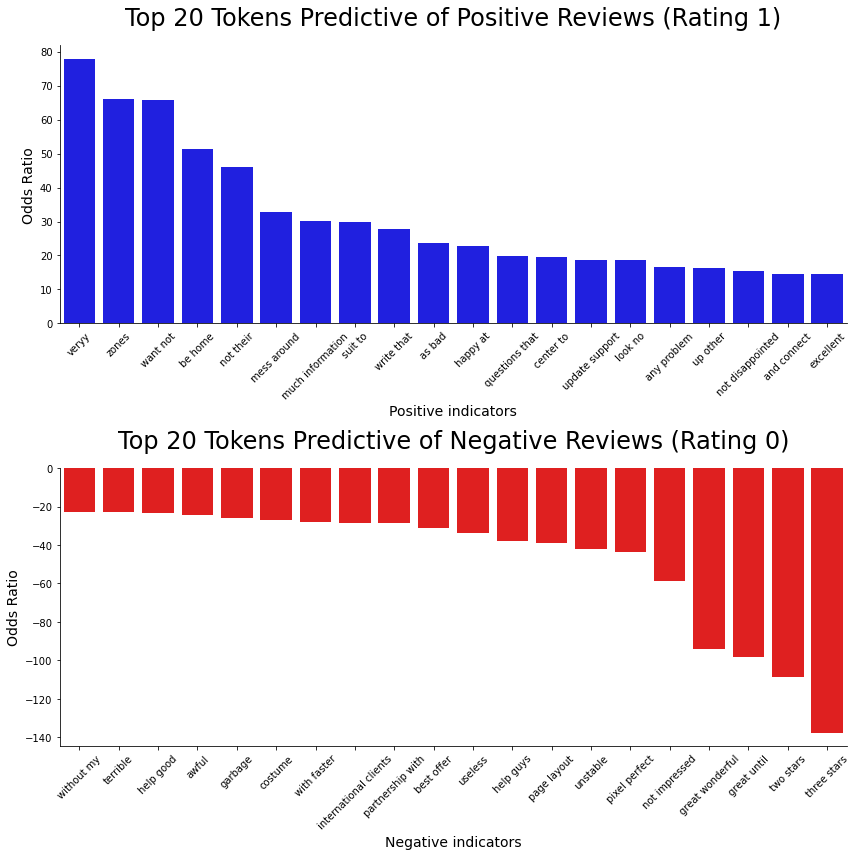

In [105]:
# Visualise the positive and negative tokens and the corresponding log odds ratio of their
# coefficients from the logistic regression
plt.subplots(nrows=2, ncols=1, figsize=(12, 12))


################### Positive Indicators Bar Plot ###################
# largest positive odds ratio -> tokens indicating positive sentiment 

plt.subplot(2, 1, 1)
sns.barplot(x = logit_coef_df['Feature'].head(20), y = logit_coef_df['Plotting_Odds_Ratio'].head(20), color="blue")

# Set titles and labels
plt.title(f"Top 20 Tokens Predictive of Positive Reviews (Rating 1)", size=24, pad=20)
plt.xlabel('Positive indicators', size=14)
plt.ylabel('Odds Ratio', size=14)
plt.xticks(rotation = 45)

# Remove top and top right graph borders
sns.despine()
plt.tight_layout()

################### Negative Indicators Bar Plot ###################
# largest negative odds ratio -> tokens indicating negative sentiment
plt.subplot(2, 1, 2)
sns.barplot(x = logit_coef_df['Feature'].tail(20), y = logit_coef_df['Plotting_Odds_Ratio'].tail(20), color="red")

# Set titles and labels
plt.title(f"Top 20 Tokens Predictive of Negative Reviews (Rating 0)", size=24, pad=20)
plt.xlabel('Negative indicators', size=14)
plt.ylabel('Odds Ratio', size=14)
plt.xticks(rotation = 45)

# Remove top and top right graph borders
sns.despine()
plt.tight_layout()

plt.show()

Of the top 20 most predictive tokens for positive reviews, "veryy", "zones", "want not", "be home", and "not their" are the top 5 predictors. However, these tokens are unexpected and does not make complete sense. This possibly reflects the overfitting of the train dataset in identifying the optimal model parameters. 

Conversely, features such as "three stars", "two stars", "great until", "great wonderful", and "not impressed" are the top 5 predictive tokens for negative reviews. Although some of these tokens may make sense, others may not be of much use and could be added to a custom stop words list. For instance, "three stars" and "two stars" are likely inherent to the rating that the review received. This redundant information may be removed with a custom stop words list. Furthermore, tokens such as "pixel perfect", "page layout", "best offer", "partnership with", "international clients", "with faster", "costume", "help good", "without my", do not really provide any negative sentiment and generally appear neutral or even positive.

### Gridsearch CV - Round 2

The next grid search will explore the following range of parameters on the train/remainder dataset:

<ol>
  <li>CountVectorizer</li>
      <ul>
      <li>Inclusion of stop words (stop_words)</li>
      <li>Additional max number of features (max_features)</li>
      <li>Bigram and trigram only n-range values (ngram_range)</li>
      </ul>
      
<br>

  <li>LogisticRegression</li>
      <ul>
      <li>Maximum numbers of iterations (max_iter)</li>
      <li>Regularization parameter (C)</li>
      </ul>
</ol>

In [106]:
# Define a pipeline that implements the steps for the transforms and final estimator

# Instantiate transformer and estimator or steps for the pipeline
estimators = [("cv", CountVectorizer()), 
              ("model", LogisticRegression(random_state=np.random.RandomState(0)))]

# Instatiate Pipeline
pipe = Pipeline(estimators, verbose=True)

In [107]:
# Define the parameters for the cross-validatation grid search to step-through
# for the estimators object (i.e., countvectorizer and logistic regression)
# created and find the best combination.

param_grid = [
    {
        "cv__stop_words": (None, 'english'),
        "cv__max_features": (60_000, 75_000),
        "cv__max_df": [(0.95)],
        "cv__ngram_range": ((1, 2), (2, 3)),
        'model': [LogisticRegression()],
        'model__max_iter': [200, 400],
        'model__penalty': ['l1'],
        'model__solver': ['liblinear'],
        'model__C': np.logspace(-1, 1, 2)
    }
]

In [108]:
# Instantiate cross-validated grid search object with the steps and parameter grid
grid_v2 = GridSearchCV(estimator=pipe,
                       param_grid=param_grid,
                       cv=5,
                       verbose=10,
                       n_jobs=1)

In [109]:
# # # Fit the grid search to the train/remainder dataset;
# # # Runtime 2h 50ms fitting 5 folds for each of 32 candidates, totalling 160 fits
# grid_v2.fit(X_remainder, y_remainder)

Save the fitted grid to a pickle file.

In [110]:
# # Save the model to a pickle file
# with open('grid_v2.pkl', 'wb') as f:
#     pickle.dump(grid_v2, f)

Load the fitted model from a pickle file.

In [111]:
# Load pickled model file
with open('grid_v2.pkl', 'rb') as f:
    grid_v2 = pickle.load(f)

Click on elements below in the diagram for details of each step in the best estimator object selected by the grid search.

In [112]:
# Check the most optimal model
grid_v2.best_estimator_

Pipeline(steps=[('cv',
                 CountVectorizer(max_df=0.95, max_features=60000,
                                 ngram_range=(1, 2))),
                ('model',
                 LogisticRegression(C=0.1, max_iter=200, penalty='l1',
                                    solver='liblinear'))],
         verbose=True)

Based on the results of the best estimator from the cross-validated grid search, the following were the optimal parameters from the current grid search:

- CountVectorizer(max_df=0.95, max_features=60_000, ngram_range=(1, 2))
- LogisticRegression(C=0.1, max_iter=200, penalty='l1', solver='liblinear')

In [113]:
# # Dataframe of cross-validated model results and corresponding model parameters
# grid_v2_scores_df = pd.DataFrame(grid_v2.cv_results_)
# grid_v2_scores_df = grid_v2_scores_df.sort_values(by=['rank_test_score']).reset_index(drop='index')
# grid_v2_scores_df

In [114]:
# # Model accuracy mean train scores from 5-fold cross-validation for each fit
# grid_v2.cv_results_['mean_train_score']

In [115]:
# # Model accuracy mean test scores from 5-fold cross-validation for each fit
# grid_v2.cv_results_['mean_test_score']

In [116]:
# Train and test score using the best estimator from the grid_v2 search
accuracy = []

accuracy.append(f"{grid_v2.score(X_remainder, y_remainder) * 100:0.1f}%")
accuracy.append(f"{grid_v2.score(X_test, y_test) * 100:0.1f}%")

print(f"Train score: {accuracy[0]}")
print(f"Test score: {accuracy[1]}")

Train score: 97.0%
Test score: 96.8%


In [117]:
# Use the function defined earlier for model performance metrics
precision, recall, f1_score = model_performance_metrics(grid_v2, 
                                                        X_remainder, 
                                                        y_remainder, 
                                                        X_test, 
                                                        y_test)

Confusion matrix for Train Data: 



,Predicted 0 [Negative Review],Predicted 1 [Positive Review]
True 0 [Negative Review],17421,9427
True 1 [Positive Review],2213,355507


Classification Report for Train Data: 

                    precision    recall  f1-score   support

Negative (Class 0)       0.89      0.65      0.75     26848
Positive (Class 1)       0.97      0.99      0.98    357720

          accuracy                           0.97    384568
         macro avg       0.93      0.82      0.87    384568
      weighted avg       0.97      0.97      0.97    384568

Confusion matrix for Test Data: 



,Predicted 0 [Negative Review],Predicted 1 [Positive Review]
True 0 [Negative Review],1868,1115
True 1 [Positive Review],249,39498


Classification Report for Test Data: 

                    precision    recall  f1-score   support

Negative (Class 0)       0.88      0.63      0.73      2983
Positive (Class 1)       0.97      0.99      0.98     39747

          accuracy                           0.97     42730
         macro avg       0.93      0.81      0.86     42730
      weighted avg       0.97      0.97      0.97     42730



In [118]:
# Compile the model performance metrics into a dataframe
model_compilation = model_compilation.append(pd.DataFrame({
                                                            'Model': 'grid_v2_best_est',
                                                            'Dataset': ['Train_Remainder', 
                                                                        'Train_Remainder',
                                                                        'Test', 
                                                                        'Test'],
                                                            'Target':['Negative (Class 0)', 
                                                                      'Positive (Class 1)',
                                                                      'Negative (Class 0)', 
                                                                      'Positive (Class 1)'],
                                                            'Accuracy': [' ', accuracy[0], ' ', accuracy[1]],
                                                            'Precision': precision,
                                                            'Recall': recall,
                                                            'F1-Score': f1_score
                                                        },
                                                        index= range(21,25)))

In [119]:
model_compilation

,Model,Dataset,Target,Accuracy,Precision,Recall,F1-Score
0,logit_v0,Train_Remainder,Negative (Class 0),,89.4%,67.9%,77.2%
1,logit_v0,Train_Remainder,Positive (Class 1),97.2%,97.6%,99.4%,98.5%
2,logit_v0,Test,Negative (Class 0),,84.4%,63.9%,72.7%
3,logit_v0,Test,Positive (Class 1),96.7%,97.3%,99.1%,98.2%
4,logit_v1,Train_Remainder,Negative (Class 0),,89.2%,69.3%,78.0%
5,logit_v1,Train_Remainder,Positive (Class 1),97.3%,97.7%,99.4%,98.5%
6,logit_v1,Test,Negative (Class 0),,85.0%,64.6%,73.4%
7,logit_v1,Test,Positive (Class 1),96.7%,97.4%,99.1%,98.3%
8,logit_v2,Train_Remainder,Negative (Class 0),,89.0%,69.0%,77.8%
9,logit_v2,Train_Remainder,Positive (Class 1),97.2%,97.7%,99.4%,98.5%


The best estimator from this grid search was actually worse than the previous one, with precision decreased from 95.9% to 88.7% and recall decreased from 81.7% to 64.9% for negative reviews within the train data. Similarly, precision decreased from 83.8% to 88.2% and a recall decreased from 68.6% to 62.6% for negative reviews within the test data. These results may be due to the stronger regularization parameter.

#### Odds Ratios

Visualize the features and corresponding odds ratios from the best estimator of the grid search.

In [120]:
logit_coef_df = pd.DataFrame({"Feature": grid_v2.best_estimator_[0].get_feature_names(),
                              "Logit_Coefficient": grid_v2.best_estimator_[1].coef_[0],
                              "Odds_Ratio": np.exp(grid_v2.best_estimator_[1].coef_[0])
                             })

In [121]:
# Sort the odds ratios; those under 1 are from a negative coefficients; convert those
# odds ratios by inversing it and turning it into a negative for appropriate 
# interpretation
logit_coef_df['Plotting_Odds_Ratio'] = np.where(logit_coef_df['Odds_Ratio'] >= 1.0, 
                                                logit_coef_df['Odds_Ratio'],
                                                -1 / logit_coef_df['Odds_Ratio'])

In [122]:
logit_coef_df = logit_coef_df.sort_values('Odds_Ratio', ascending = False)

In [123]:
logit_coef_df

,Feature,Logit_Coefficient,Odds_Ratio,Plotting_Odds_Ratio
1809,amaze,2.119816,8.329602,8.329602
9824,cannot wait,2.037598,7.672155,7.672155
16469,excellent,1.986721,7.291585,7.291585
17106,fantastic,1.850689,6.364205,6.364205
5735,awesome,1.834256,6.260473,6.260473
...,...,...,...,...
5843,awful,-2.138111,0.117877,-8.483397
51703,three stars,-2.390859,0.091551,-10.922874
55408,useless,-2.451651,0.086151,-11.607499
48080,terrible,-2.500843,0.082016,-12.192769


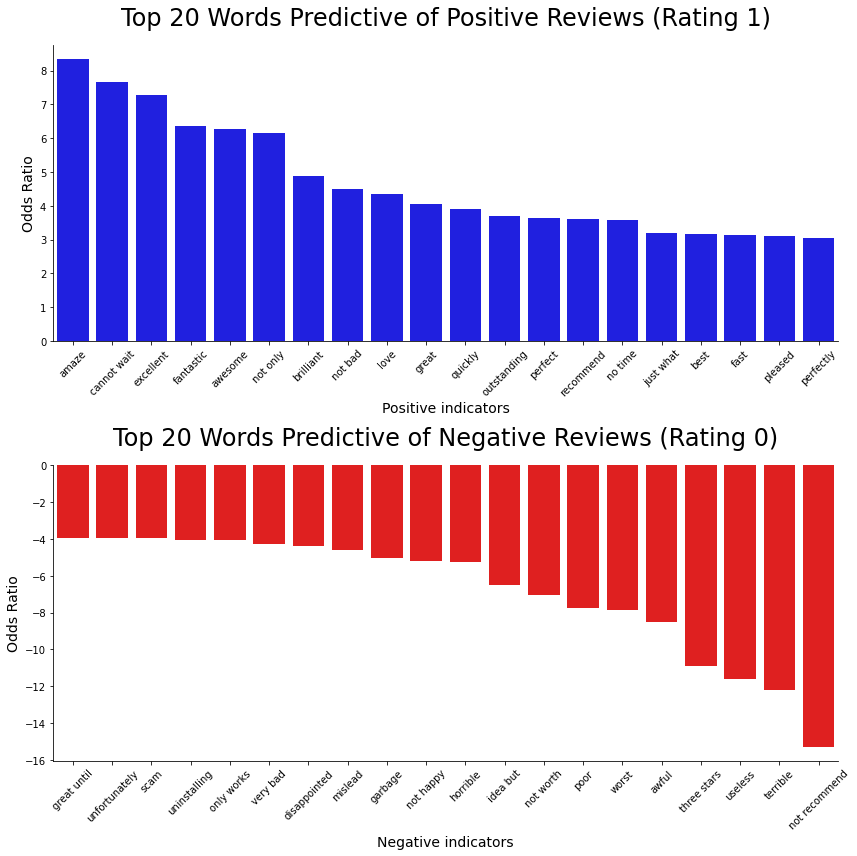

In [124]:
# Visualise the positive and negative tokens and their corresponding log odds ratio of their
# coefficients from the logistic regression
plt.subplots(nrows=2, ncols=1, figsize=(12, 12))


################### Positive Indicators Bar Plot ###################
################### largest positive coefficient -> tokens indicating positive sentiment 

plt.subplot(2, 1, 1)
sns.barplot(x = logit_coef_df['Feature'].head(20), y = logit_coef_df['Plotting_Odds_Ratio'].head(20), color="blue")

# Set titles and labels
plt.title(f"Top 20 Words Predictive of Positive Reviews (Rating 1)", size=24, pad=20)
plt.xlabel('Positive indicators', size=14)
plt.ylabel('Odds Ratio', size=14)
plt.xticks(rotation = 45)

# Remove top and top right graph borders
sns.despine()
plt.tight_layout()

################### Negative Indicators Bar Plot ###################
################### largest negative coefficient -> tokens indicating negative sentiment 
plt.subplot(2, 1, 2)
sns.barplot(x = logit_coef_df['Feature'].tail(20), y = logit_coef_df['Plotting_Odds_Ratio'].tail(20), color="red")

# Set titles and labels
plt.title(f"Top 20 Words Predictive of Negative Reviews (Rating 0)", size=24, pad=20)
plt.xlabel('Negative indicators', size=14)
plt.ylabel('Odds Ratio', size=14)
plt.xticks(rotation = 45)

# Remove top and top right graph borders
sns.despine()
plt.tight_layout()

plt.show()


Of the top 20 most predictive tokens for positive reviews, "amaze", "cannot wait", "excellent", "fantastic", and "awesome" are the top 5 predictors. These tokens make sense as to what can be expected from positive reviews. The precision and recall for this model did not exhibit overfitting of the train dataset as observed in the grid search from round 1. 

Conversely, features such as "not recommend", "terrible", "useless", "three stars", and "awful" are the top 5 predictive tokens for negative reviews. Most of these tokens in the top 20 reflect negative sentiment and make sense in being predictive for negative reviews. For instance, "poor", "not worth", "horrible", "not happy", "garbage", "mislead", "disappointed", "very bad", "uninstalling", "scam", "unfortunately", and "great until" tokens have some general negative sentiment and may reflect a better fitted model compared to that observed in the grid search from round 1.

Furthermore, the odds ratios are in reasonable magnitudes as a result of the regularization parameter implemented.

In [125]:
# #######################################################
# ################### OPTIONAL GRAPHS ###################
# #######################################################


# # Visualise the positive and negative tokens and their corresponding log odds ratio of their
# # coefficients from the logistic regression


# ################### Positive Indicators HORIZONTAL Bar Plot ###################
# ################### largest positive coefficient -> tokens indicating positive sentiment 

# data = logit_coef_df['Plotting_Odds_Ratio'].head(10).values
# df = pd.DataFrame(data,columns=['Plotting_Odds_Ratio'], index = logit_coef_df['Feature'].head(10))

# df.sort_values(by = 'Plotting_Odds_Ratio', ascending = True).plot.barh(figsize = (15,10), legend=None)

# # Set titles and labels
# plt.title(f"Top 10 Words Predictive of Positive Reviews (Rating 1)", size=24, pad=20)
# plt.ylabel('', size=14)
# plt.xlabel('Odds Ratio', size=16)

# # Set axes tick labels
# plt.yticks(size = 20)

# # Remove top and top right graph borders
# sns.despine()

# # Save figure as support vector graphics for further customization in microsoft powerpoint
# plt.savefig("positive_predictors.svg")
# plt.show()

In [126]:
# # Visualise the positive and negative tokens and their corresponding log odds ratio of their
# # coefficients from the logistic regression


# ################### Negative Indicators HORIZONTAL Bar Plot ###################
# ################### largest negative coefficient -> tokens indicating negative sentiment 

# data = logit_coef_df['Plotting_Odds_Ratio'].tail(10).values
# df = pd.DataFrame(data,columns=['Plotting_Odds_Ratio'], index = logit_coef_df['Feature'].tail(10))

# df.sort_values(by = 'Plotting_Odds_Ratio', ascending = False).plot.barh(figsize = (15,10), legend=None, color = 'crimson')

# # Set titles and labels
# plt.title(f"Top 10 Words Predictive of Negative Reviews (Rating 0)", size=24, pad=20)
# plt.ylabel('', size=14)
# plt.xlabel('Odds Ratio', size=16)

# # Set axes tick labels
# plt.yticks(size = 20)


# # Remove top and top right graph borders
# sns.despine()

# # Save figure as support vector graphics for further customization in microsoft powerpoint
# plt.savefig("negative_predictors.svg")
# plt.show()

# Summary

The data-centric approach was briefly highlighted during the comparison of the logit model performance metrics when comparing the model using reviews without any text pre-processing or language separation to the model using English-only language reviews with text pre-processing.

In comparing the performance metrics with the reviews that underwent different text pre-processing steps, the verb lemmatized English-only reviews exhibited minimal to no change in the model performance metrics with the test data compared to the other text-preprocessed datasets used. As a result, optimization of hyperparameters were based on the text normalized English reviews for the rest of the notebook.

With 5-fold cross-validation grid search of hyperparameters for CountVectorizer and LogisticRegression, the optimal estimator object selected was from grid search round 2. The hyperparameters were the following:

- CountVectorizer(max_df=0.95, max_features=60_000, ngram_range=(1, 2))
- LogisticRegression(C=0.1, max_iter=200, penalty='l1', solver='liblinear')

Furthermore, despite the stronger model performance metrics for negative reviews observed during grid search round 1 compared to round 2, this conclusion was made in conjunction with the visualization of the top 20 most predictive tokens for positive and negative reviews. 

In adopting the model-centric approach, further fine-tuning of the grid search optimization can be made to the hyperparameters in future analyses. At this time, the CountVectorizer parameters used in grid search round 2 will be used for topic modeling. This approach is adopted to conduct the analyses in-series, such that the topic modeling will help further explain the results observed in logistic regression by uncovering hidden themes related to the tokens observed. 